<a href="https://colab.research.google.com/github/nonafalaki/Multimodal-Framework/blob/main/House_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unrar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x '/content/Houses Dataset.rar'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# **Reading The  Tabular dataset**

In [ ]:
import pandas as pd 
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
inputpath='/content/drive/MyDrive/Houses Dataset/HousesInfo.txt'
df_houses = pd.read_csv(inputpath, sep=" ", header=None, names=cols)

In [ ]:
df_houses

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [ ]:
df_houses.describe()

,bedrooms,bathrooms,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


### **Preprocessing the Tabular dataset**

In [ ]:
#Check duplicate value
df_houses.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
530    False
531    False
532    False
533    False
534    False
Length: 535, dtype: bool

In [ ]:
#check null values
df_houses.isnull().sum()

bedrooms     0
bathrooms    0
area         0
zipcode      0
price        0
dtype: int64

**Check for Outliers**

In [ ]:
#BoxPlot_visualization 
import seaborn as sns
import matplotlib.pyplot as plt
def Box_plot(df):
  fig=plt.figure(figsize=[25,20])

  plt.subplot(5,6,1)
  sns.boxplot(x="bedrooms", data=df)

  plt.subplot(5,6,2)
  sns.boxplot(x='bathrooms', data=df)

  plt.subplot(5,6,3)
  sns.boxplot(x='area', data=df)

  plt.subplot(5,6,4)
  sns.boxplot(x='zipcode', data=df)

  plt.subplot(5,6,5)
  sns.boxplot(x="price", data=df)

  plt.show()

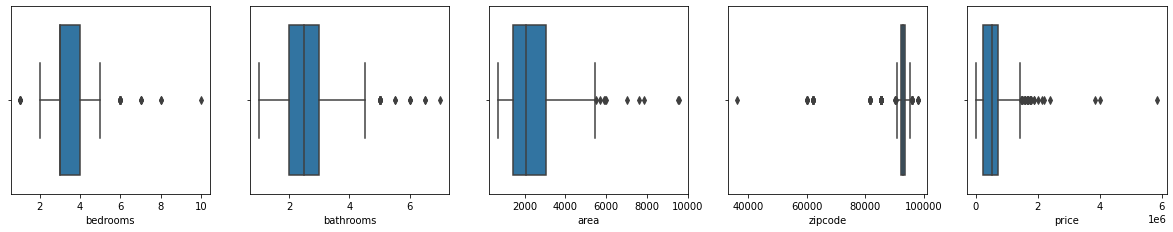

In [ ]:
Box_plot(df_houses)

In [ ]:
#Median_imputation to remove outlier

def median_imputation_outlier(df,col):
  sns.boxplot(x=col, data=df)
  plt.title("Box Plot before median imputation")
  plt.show()
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  Lower_tail = q1 - 1.5 * iqr
  Upper_tail = q3 + 1.5 * iqr
  med = np.median(df[col])
  for i in df[col]:
    if i > Upper_tail or i < Lower_tail:
      df[col] = df[col].replace(i, med)
  sns.boxplot(x=col, data=df)
  plt.title("Box Plot after median imputation")
  plt.show()

In [ ]:
imp_features=df_houses.columns[:-1]

In [ ]:
imp_features

Index(['bedrooms', 'bathrooms', 'area', 'zipcode'], dtype='object')

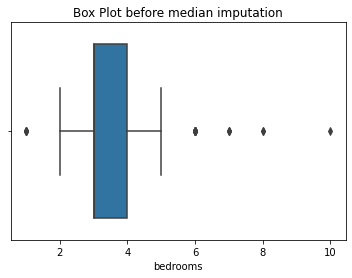

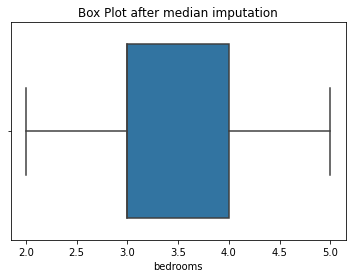

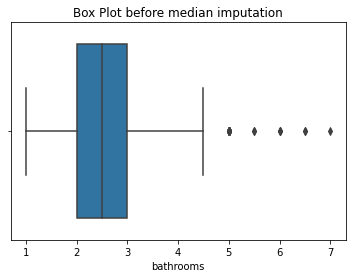

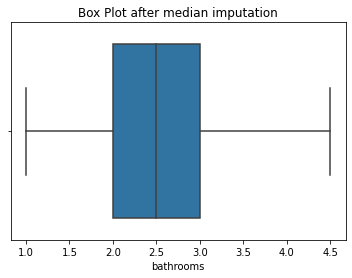

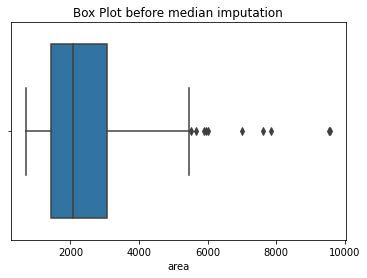

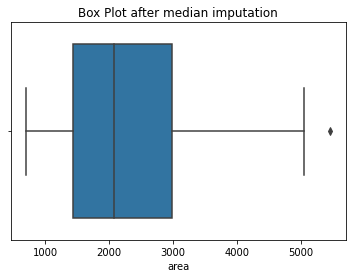

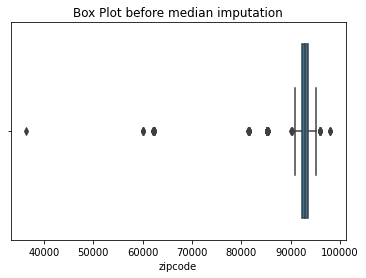

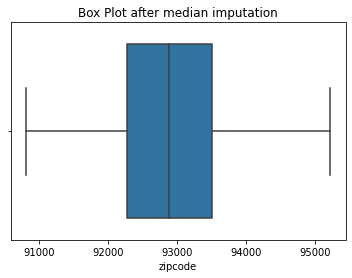

In [ ]:
for i in imp_features:
  median_imputation_outlier(df_houses,i)

In [ ]:
df_houses.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,92880,869500
1,4,3.0,3343,92880,865200
2,3,4.0,3923,92880,889000
3,5,2.5,4022,92880,910000
4,3,4.0,4116,92880,971226


**Check Multicollinearity**

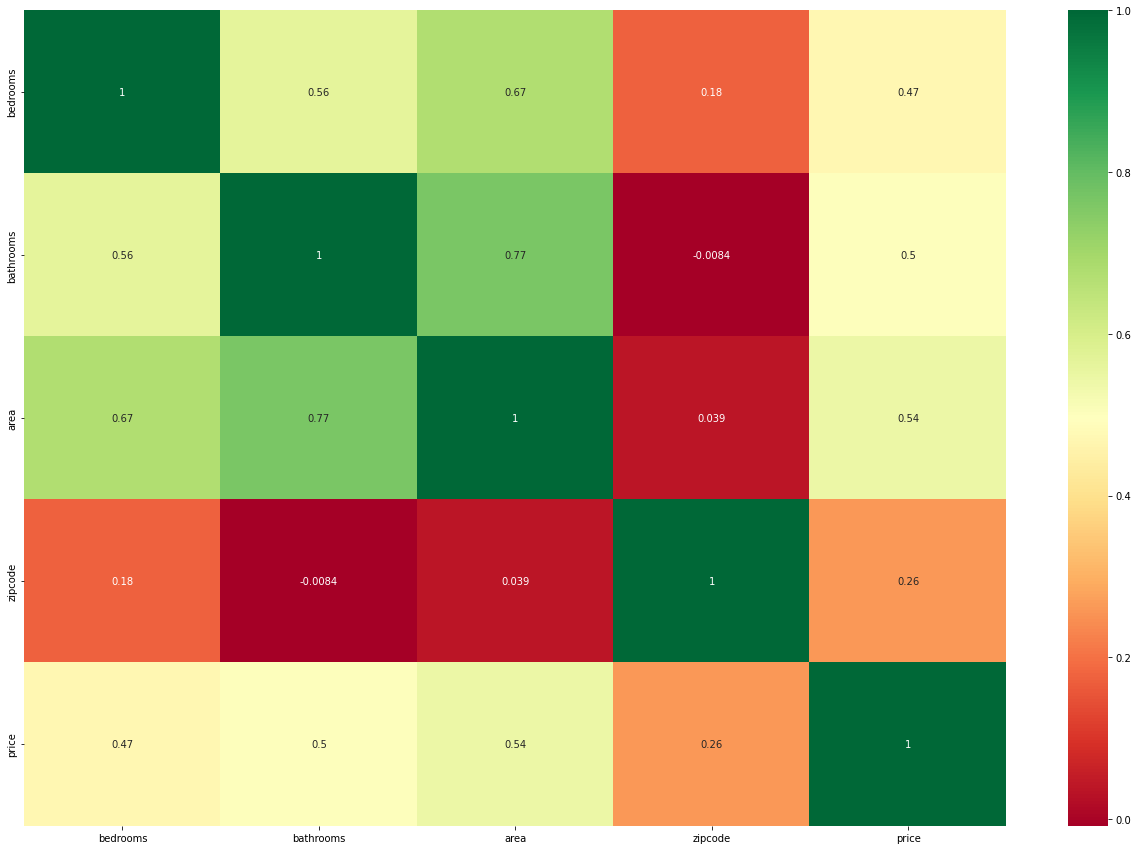

In [ ]:
plt.figure(figsize=(22,15))
cor = df_houses.corr()
sns.heatmap(cor, annot=True, cmap="RdYlGn")
plt.show()

In [ ]:
X = df_houses.drop("price",axis="columns")
y = df_houses.price

**Feature Engineering**

In [ ]:
X

,bedrooms,bathrooms,area,zipcode
0,4,4.0,4053,85255
1,4,3.0,3343,36372
2,3,4.0,3923,85266
3,5,5.0,4022,85262
4,3,4.0,4116,85266
...,...,...,...,...
530,5,2.0,2066,94531
531,4,3.5,9536,94531
532,3,2.0,2014,94531
533,4,3.0,2312,94531


In [ ]:
from itertools import combinations
columns_list = X.columns
interactions = list(combinations(columns_list, 2))

In [ ]:
from sklearn.linear_model import LinearRegression
interaction_dict = {}
for interaction in interactions:
   X_train_int = X
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr3 = LinearRegression()
   lr3.fit(X_train_int, y)
   interaction_dict[lr3.score(X_train_int, y)] = interaction

In [ ]:
top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
   print(interaction_dict[interaction])

('bedrooms', 'area')
('bathrooms', 'area')
('bedrooms', 'bathrooms')
('area', 'zipcode')
('bathrooms', 'zipcode')


In [ ]:
#combine bedroom and area as new feature
df_houses['bed_area'] = df_houses['bedrooms'] * df_houses['area']

In [ ]:
df_houses

,bedrooms,bathrooms,area,zipcode,price,bed_area
0,4,4.0,4053,85255,869500,16212
1,4,3.0,3343,36372,865200,13372
2,3,4.0,3923,85266,889000,11769
3,5,5.0,4022,85262,910000,20110
4,3,4.0,4116,85266,971226,12348
...,...,...,...,...,...,...
530,5,2.0,2066,94531,399900,10330
531,4,3.5,9536,94531,460000,38144
532,3,2.0,2014,94531,407000,6042
533,4,3.0,2312,94531,419000,9248


**Plot feature importance**

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(objective='multi:softprob')

In [ ]:
def feature_importance_plot(model,X):
  temp = pd.DataFrame()
  temp['attr'] = X.columns
  temp['importance'] = model.feature_importances_
  temp = temp.sort_values(by='importance', ascending=False)
  plt.figure(figsize=(10, 10))
  plt.barh(y=temp['attr'], width=temp['importance'])
  plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
  plt.xlabel('Importance', fontsize=14, labelpad=20)
  plt.show()


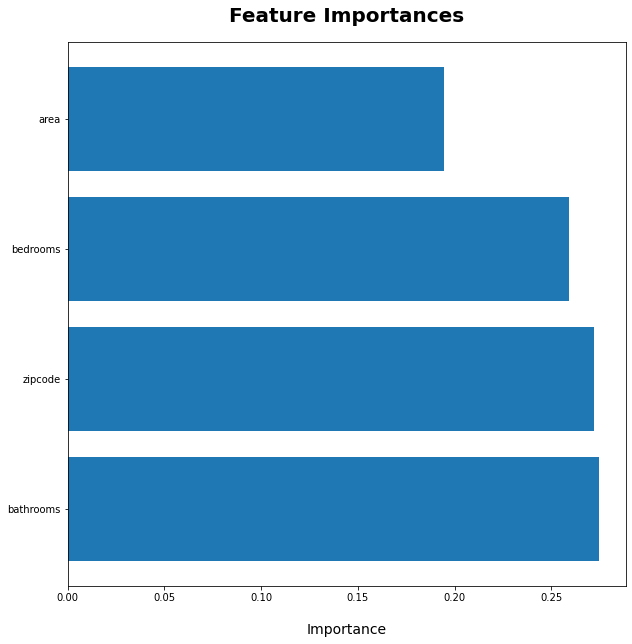

In [ ]:
feature_importance_plot(model,X)

## **Read Image dataset**

In [ ]:
from pandas.core.groupby import base
import os
import glob
import cv2
images = []
Path='/content/drive/MyDrive/Houses Dataset'
for i in df_houses.index.values:
  basePath = os.path.sep.join([Path, "{}_*".format(i + 1)])
  housePaths = sorted(list(glob.glob(basePath)))
  inputImages = []
  outputImage = np.zeros((64, 64, 3), dtype="uint8")
  for housePath in housePaths:
    image = cv2.imread(housePath)
    image = cv2.resize(image, (32, 32))
    inputImages.append(image)

  outputImage[0:32, 0:32] = inputImages[0]
  outputImage[0:32, 32:64] = inputImages[1]
  outputImage[32:64, 32:64] = inputImages[2]
  outputImage[32:64, 0:32] = inputImages[3]
	# add the tiled image to our set of images the network will be
	# trained on
  images.append(outputImage)



In [ ]:
images = np.array(images) / 255.0

In [ ]:
np.shape(images)

(535, 64, 64, 3)

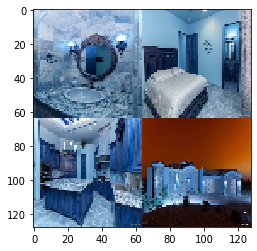

In [ ]:
plt.imshow(images[1][:,:,:], interpolation='nearest')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
split = train_test_split(df_houses, images, test_size=0.20, random_state=42)
(train_dfX, test_dfX, trainImagesX, testImagesX) = split


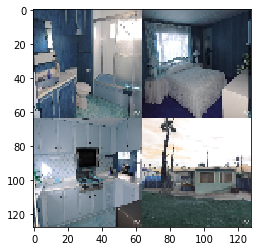

In [ ]:
plt.imshow(trainImagesX[1][:,:,:], interpolation='nearest')
plt.show()

In [ ]:
maxPrice = train_dfX["price"].max()
trainY = train_dfX["price"] / maxPrice
testY = test_dfX["price"] / maxPrice

In [ ]:
min(trainY),max(trainY)

(0.01571429693878353, 1.0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
def process_house_features(df, train, test):
	con_features = ["bedrooms", "bathrooms", "area"]
	minmax = MinMaxScaler()
	trainContinuous = minmax.fit_transform(train[con_features])
	testContinuous = minmax.transform(test[con_features])

	Binarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = Binarizer.transform(train["zipcode"])
	testCategorical = Binarizer.transform(test["zipcode"])

	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
	return (trainX, testX)
 

In [ ]:
(train_dfX, test_dfX) =process_house_features(df_houses,train_dfX,test_dfX)

In [ ]:
# import the necessary packages
def mlp_ml(dim, regress=False):
	# define our MLP network
  model = Sequential()
  model.add(Dense(8, input_dim=dim, activation="relu",kernel_regularizer=keras.regularizers.l1(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(4, activation="relu"))
  if regress:
    model.add(Dense(1, activation="linear"))
  # return our model
  return model

In [ ]:
mlp = mlp_ml(train_dfX.shape[1], regress=True)

In [ ]:
opt=Adam(lr=1e-3, decay=1e-3 / 200)
mlp.compile(loss='mean_absolute_percentage_error', optimizer=opt)
history = mlp.fit(train_dfX,trainY,validation_data=(test_dfX,testY),batch_size=8,epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


54/54 [==============================] - 1s 5ms/step - loss: 452.1292 - val_loss: 164.4766
Epoch 2/200
54/54 [==============================] - 0s 2ms/step - loss: 116.1485 - val_loss: 78.6024
Epoch 3/200
54/54 [==============================] - 0s 2ms/step - loss: 80.2248 - val_loss: 68.2369
Epoch 4/200
54/54 [==============================] - 0s 2ms/step - loss: 65.5050 - val_loss: 57.9960
Epoch 5/200
54/54 [==============================] - 0s 2ms/step - loss: 62.4647 - val_loss: 61.5546
Epoch 6/200
54/54 [==============================] - 0s 2ms/step - loss: 63.8525 - val_loss: 57.9584
Epoch 7/200
54/54 [==============================] - 0s 2ms/step - loss: 58.7390 - val_loss: 61.6794
Epoch 8/200
54/54 [==============================] - 0s 2ms/step - loss: 57.3699 - val_loss: 61.0986
Epoch 9/200
54/54 [==============================] - 0s 2ms/step - loss: 57.8861 - val_loss: 67.8206
Epoch 10/200
54/54 [==============================] - 0s 2ms/step - loss: 57.0402 - val_loss: 63.740

## **Train MLP model with adding  new feature**

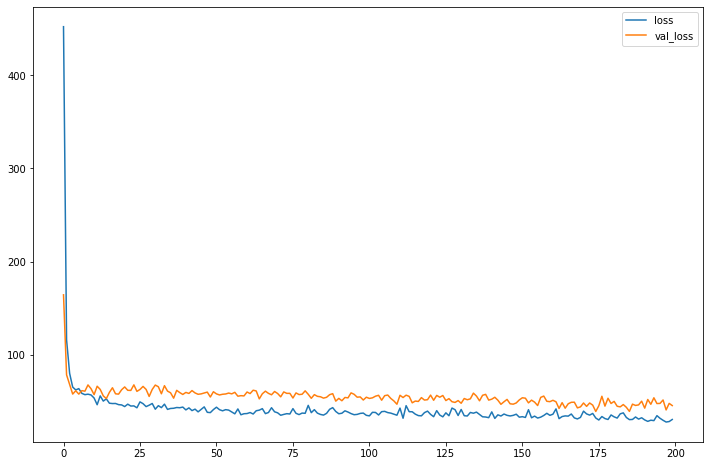

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
preds = mlp.predict([test_dfX])

In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 45.66%, std: 59.23%


MAE: 0.029080153493968815
MSE: 0.002205011952356512
RMSE: 0.04695755479533099
VarScore: 0.4798901716726828


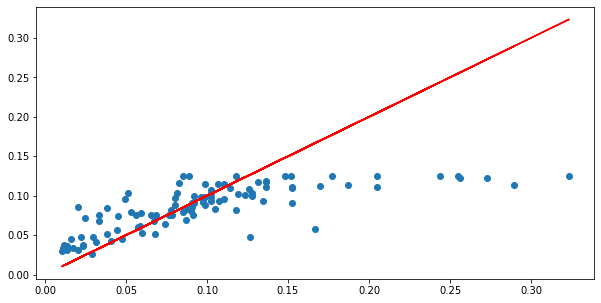

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.45


## **Train MLP model without replacing outliers**

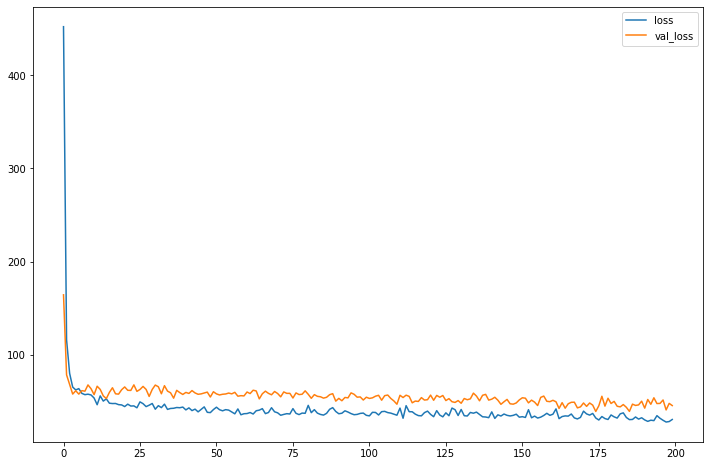

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
preds = mlp.predict([test_dfX])

In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 27.19%, std: 29.13%


MAE: 0.024351582141698316
MSE: 0.0015956466969308395
RMSE: 0.039945546647039885
VarScore: 0.628748666488024


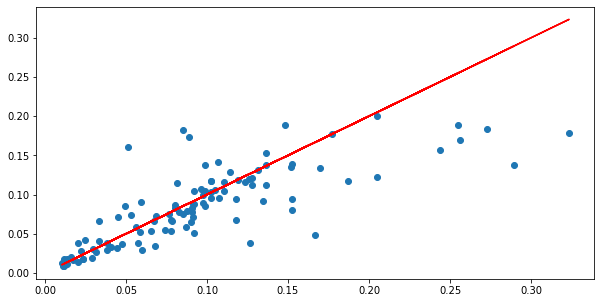

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.6


## **Train MLP model with replaced outliers**

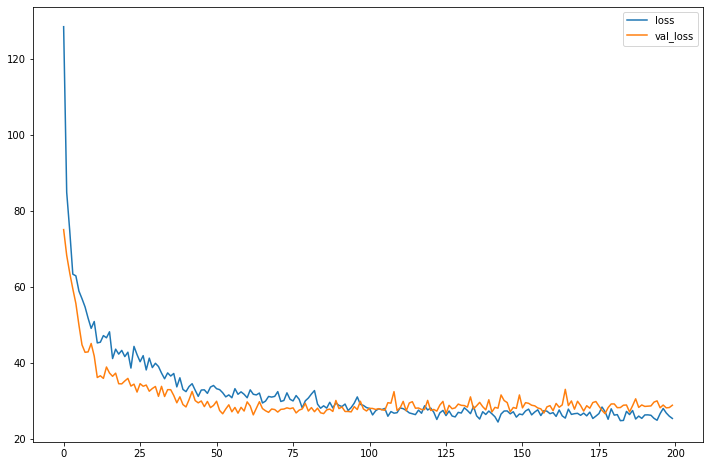

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
preds = mlp.predict([test_dfX])

In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 28.80%, std: 21.77%


MAE: 0.029313373253283433
MSE: 0.0021678627470420883
RMSE: 0.04656031300412496
VarScore: 0.6014659906973823


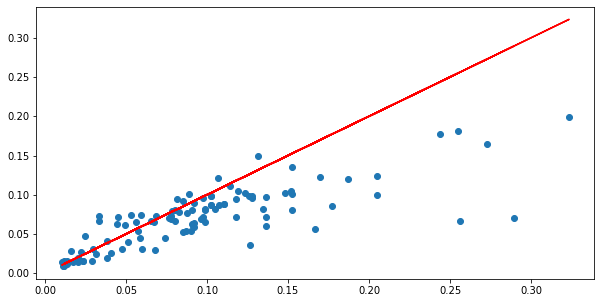

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.46


## **Implement Multimodal model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

In [ ]:
from tensorflow.keras.optimizers import Adam

## **Transfer learning in combination with MLP**

In [ ]:
#import keras
import tensorflow as tf
from tensorflow.keras import applications 
def create_transfer_learning(train_data,regress):
  model = applications.VGG16(include_top = False, weights = 'imagenet')
  #Top model:
  model = Sequential()
  model.add(Flatten(input_shape = train_data.shape[1:]))
  model.add(Dense(256,activation = 'relu'))
  model.add(Dropout(0.1))
  if regress:
    model.add(Dense(1,activation = 'sigmoid'))
  return model  

In [ ]:
transfer_model=create_transfer_learning(trainImagesX,regress=False)

In [ ]:
# create the MLP and transfer models
mlp_model = mlp_ml(train_dfX.shape[1],regress=False)
transfer =create_transfer_learning(trainImagesX, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and transfer
combinedInput = concatenate([mlp_model.output, transfer.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
#x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(combinedInput)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp_model.input, transfer.input], outputs=x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **AlexNet in combination with MLP**

In [ ]:
#Alexnet implementation
model = Sequential()
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=trainImagesX.shape[1:]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))



In [ ]:
# create the MLP and Alexnet models
mlp = mlp_ml(train_dfX.shape[1], regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, model.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, model.input], outputs=x)

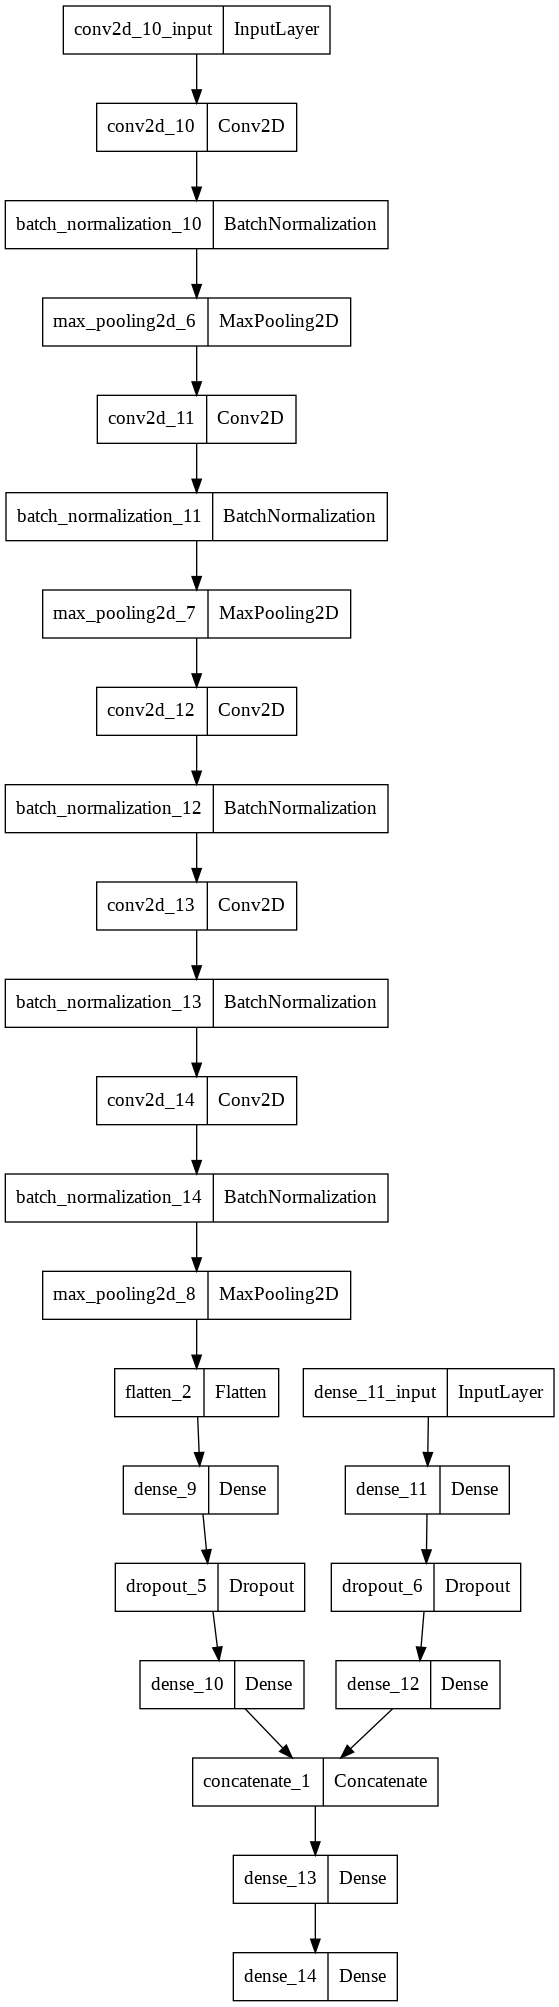

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True))

In [ ]:
opt = Adam(lr=1e-3, decay=1e-3 / 150)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
model.fit(
	x=[train_dfX, trainImagesX], y=trainY,
	validation_data=([test_dfX, testImagesX], testY),
	epochs=150, batch_size=64)

[INFO] training model...
Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 20s 3s/step - loss: 1421.3601 - val_loss: 98.9623
Epoch 2/150
6/6 [==============================] - 18s 3s/step - loss: 97.9569 - val_loss: 96.4774
Epoch 3/150
6/6 [==============================] - 18s 3s/step - loss: 95.4824 - val_loss: 93.5688
Epoch 4/150
6/6 [==============================] - 17s 3s/step - loss: 92.4615 - val_loss: 90.6007
Epoch 5/150
6/6 [==============================] - 18s 3s/step - loss: 89.5868 - val_loss: 87.6352
Epoch 6/150
6/6 [==============================] - 18s 3s/step - loss: 86.9570 - val_loss: 84.7995
Epoch 7/150
6/6 [==============================] - 18s 3s/step - loss: 84.0918 - val_loss: 82.1393
Epoch 8/150
6/6 [==============================] - 18s 3s/step - loss: 81.6129 - val_loss: 79.4897
Epoch 9/150
6/6 [==============================] - 18s 3s/step - loss: 79.1738 - val_loss: 77.0085
Epoch 10/150
6/6 [==============================] - 18s 3s/step - loss: 77.0806 - val_loss: 74.9245
Epoch 11/150
6/6 [=

In [ ]:
# create the MLP and transfer models
mlp_model = mlp_ml(train_dfX.shape[1],regress=False)
transfer =model(trainImagesX, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and transfer
combinedInput = concatenate([mlp_model.output, transfer.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
#x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(combinedInput)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp_model.input, transfer.input], outputs=x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)


In [ ]:
# train the model
print("training model...")
history=model.fit(x=[train_dfX, trainImagesX], y=trainY,validation_data=([test_dfX, testImagesX], testY),
epochs=200)

training model...
Epoch 1/200
12/12 [==============================] - 1s 78ms/step - loss: 19113.9629 - val_loss: 3055.5242
Epoch 2/200
12/12 [==============================] - 1s 67ms/step - loss: 1412.2456 - val_loss: 410.7863
Epoch 3/200
12/12 [==============================] - 1s 68ms/step - loss: 161.9205 - val_loss: 94.3848
Epoch 4/200
12/12 [==============================] - 1s 68ms/step - loss: 90.5810 - val_loss: 83.9049
Epoch 5/200
12/12 [==============================] - 1s 68ms/step - loss: 81.3004 - val_loss: 77.0780
Epoch 6/200
12/12 [==============================] - 1s 68ms/step - loss: 75.9211 - val_loss: 73.5782
Epoch 7/200
12/12 [==============================] - 1s 67ms/step - loss: 73.3036 - val_loss: 70.8502
Epoch 8/200
12/12 [==============================] - 1s 68ms/step - loss: 72.3582 - val_loss: 68.3624
Epoch 9/200
12/12 [==============================] - 1s 65ms/step - loss: 69.5131 - val_loss: 65.6007
Epoch 10/200
12/12 [==============================] - 1

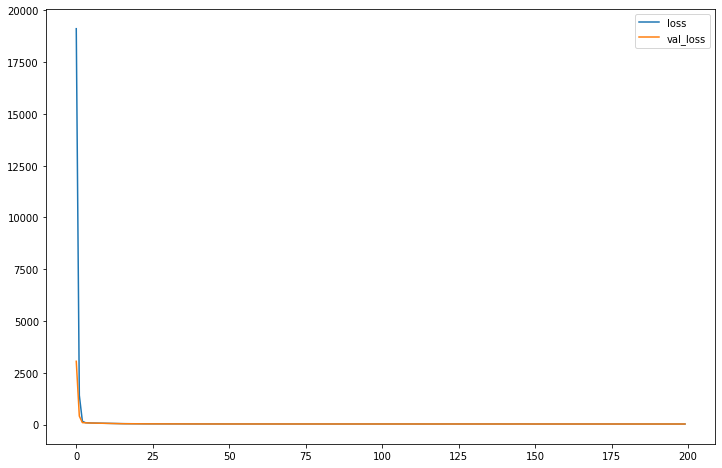

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
# make predictions on the testing data
print("predicting house prices...")
preds = model.predict([test_dfX, testImagesX])

predicting house prices...


In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $504,611.41, std house price: $298,481.51
[INFO] mean: 26.98%, std: 26.01%


MAE: 0.09252069730670134
MSE: 0.019822520585640883
RMSE: 0.1407924734694326
VarScore: 0.598240706658522


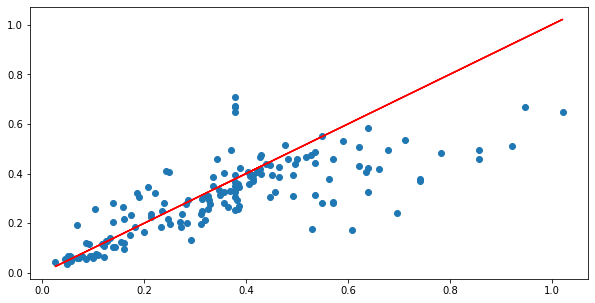

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.54


In [ ]:
trainImagesX.shape[1:]

(64, 64, 3)

## **CNN combined with MLP**

In [ ]:

def create_cnn(width, height, depth, filters=(32, 64, 128), regress=False):
  # initialize the input shape and channel dimension, assuming
  # TensorFlow/channels-last ordering
  inputShape = (height, width, depth)
  chanDim = -1
  # define the model input
  inputs = Input(shape=inputShape)
  # loop over the number of filters
  for (i, f) in enumerate(filters):
	  # if this is the first CONV layer then set the input
		# appropriately
    if i == 0:
      x = inputs
		# CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

  # flatten the volume, then FC => RELU => BN => DROPOUT
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(0.25)(x)
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
  x = Dense(4)(x)
  x = Activation("relu")(x)
	# check to see if the regression node should be added
  if regress:
    x = Dense(1, activation="linear")(x)
  # construct the CNN
  model = Model(inputs, x)
  # return the CNN
  return model

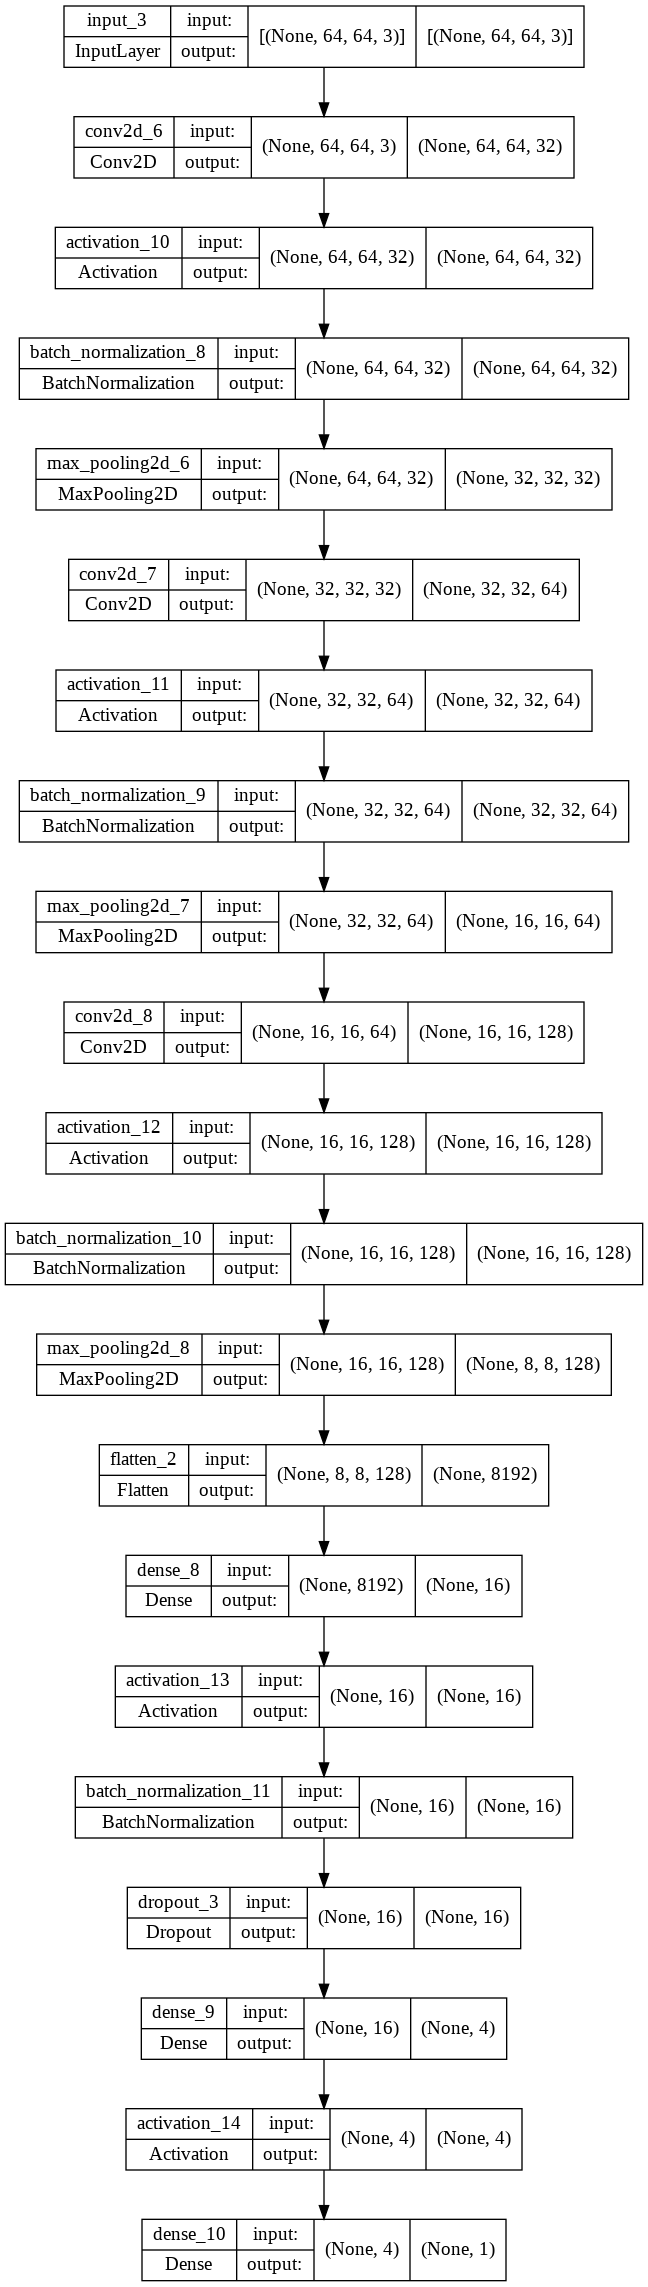

In [ ]:
from tensorflow.keras.utils import plot_model
model = create_cnn(64, 64, 3, regress=True)
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [ ]:
# create the MLP and CNN models
mlp = mlp_ml(train_dfX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [ ]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
history=model.fit(
	x=[train_dfX, trainImagesX], y=trainY,
	validation_data=([test_dfX, testImagesX], testY),
	epochs=200, batch_size=8)

[INFO] training model...
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


54/54 [==============================] - 7s 100ms/step - loss: 324.0660 - val_loss: 790.5871
Epoch 2/200
54/54 [==============================] - 5s 97ms/step - loss: 154.5407 - val_loss: 5896.2622
Epoch 3/200
54/54 [==============================] - 5s 98ms/step - loss: 94.5454 - val_loss: 9045.8047
Epoch 4/200
54/54 [==============================] - 5s 99ms/step - loss: 72.1106 - val_loss: 7325.9321
Epoch 5/200
54/54 [==============================] - 5s 99ms/step - loss: 70.3110 - val_loss: 5629.3540
Epoch 6/200
54/54 [==============================] - 5s 98ms/step - loss: 57.9462 - val_loss: 3453.9417
Epoch 7/200
54/54 [==============================] - 5s 100ms/step - loss: 61.4611 - val_loss: 4152.2988
Epoch 8/200
54/54 [==============================] - 5s 99ms/step - loss: 74.9371 - val_loss: 4570.3052
Epoch 9/200
54/54 [==============================] - 5s 98ms/step - loss: 58.5605 - val_loss: 242.2750
Epoch 10/200
54/54 [==============================] - 6s 112ms/step - loss

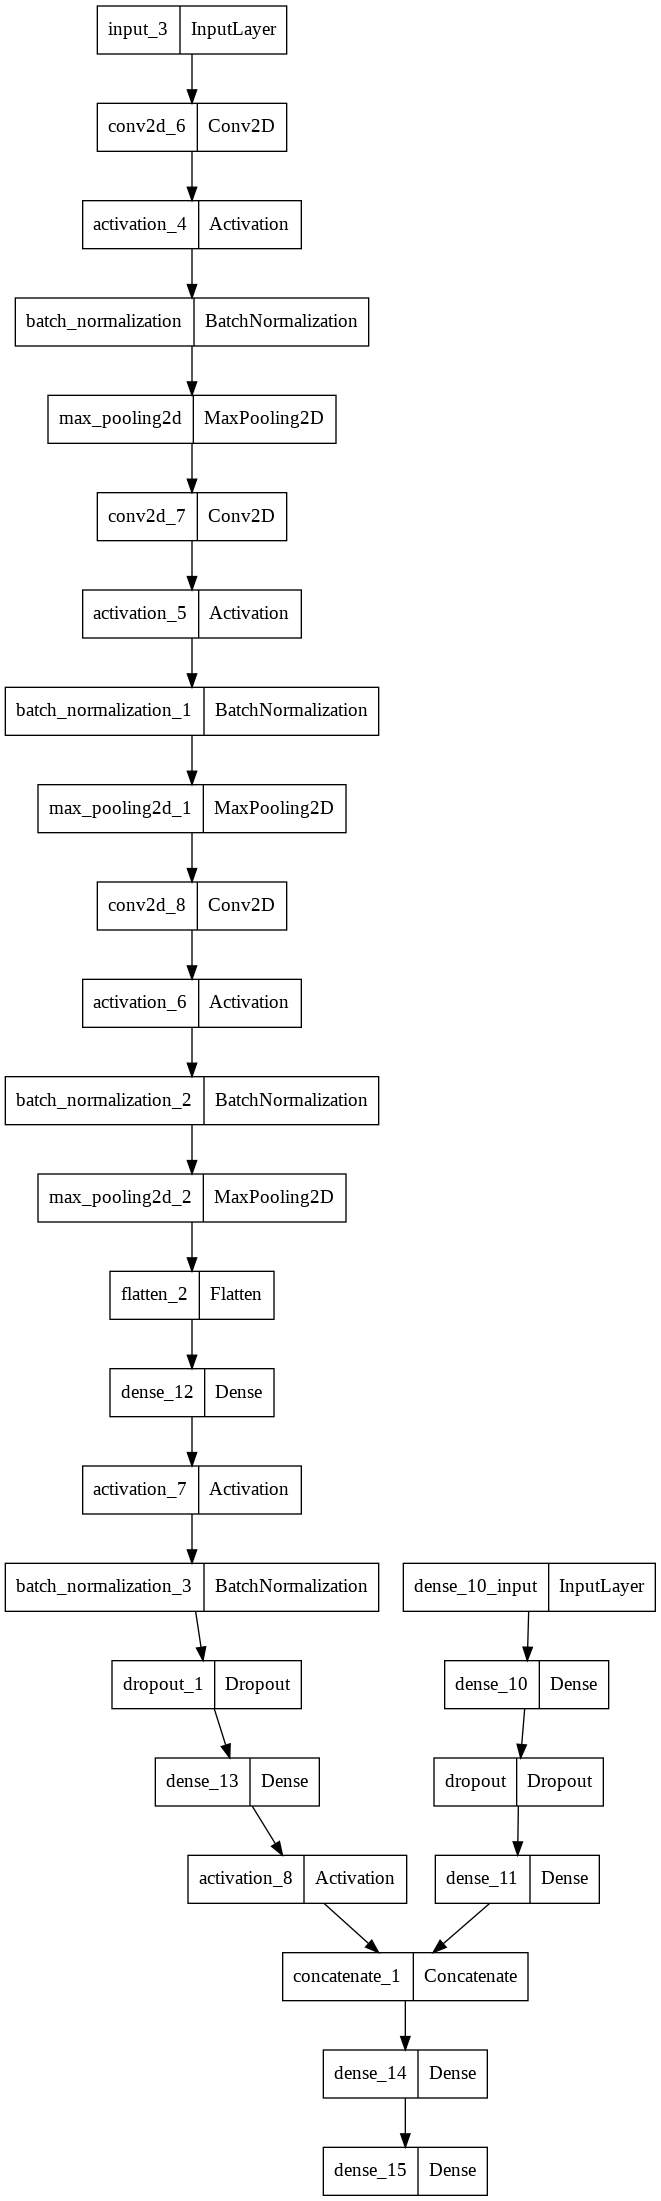

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

### **Results of training the model with new feature**

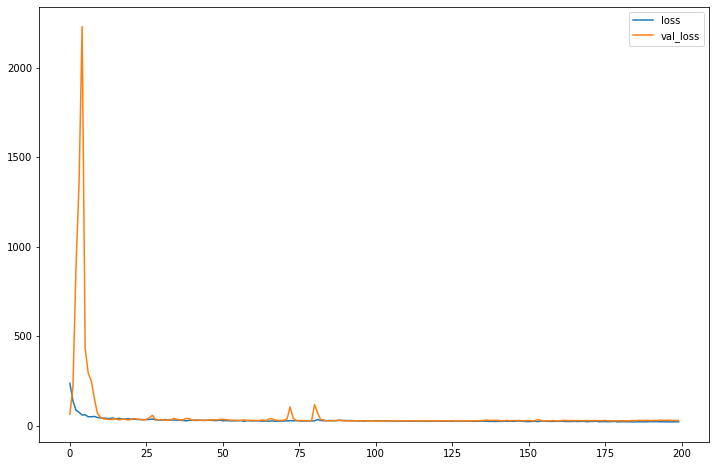

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
# make predictions on the testing data
print("predicting house prices...")
preds = model.predict([test_dfX, testImagesX])

predicting house prices...


In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 28.89%, std: 29.93%


MAE: 0.026548643579216647
MSE: 0.0017806486905861858
RMSE: 0.04219773323990503
VarScore: 0.6386142183531277


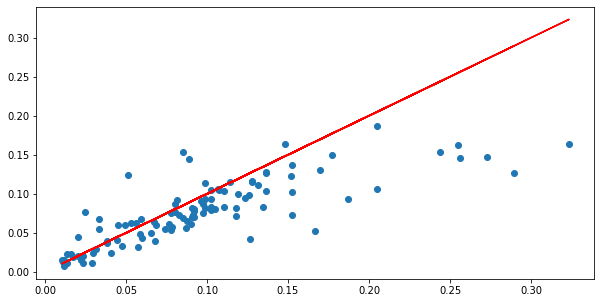

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.56


### **Results of training the model without replacing outliers**

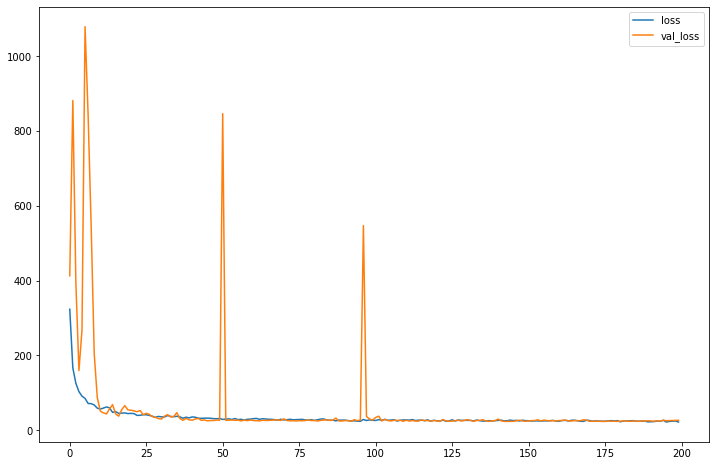

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
# make predictions on the testing data
print("predicting house prices...")
preds = model.predict([test_dfX, testImagesX])

predicting house prices...


In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 26.48%, std: 33.68%


MAE: 0.021500286349729086
MSE: 0.0013660284524975766
RMSE: 0.036959822138337955
VarScore: 0.6715889341826935


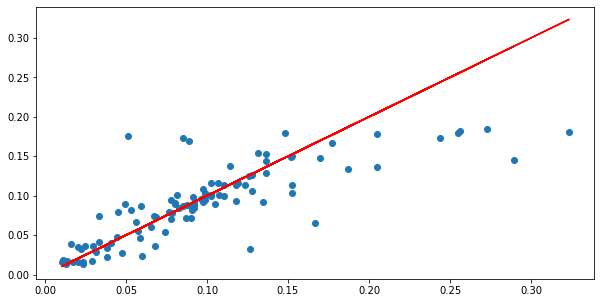

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.66


### **Results of training the model with replacing outliers**

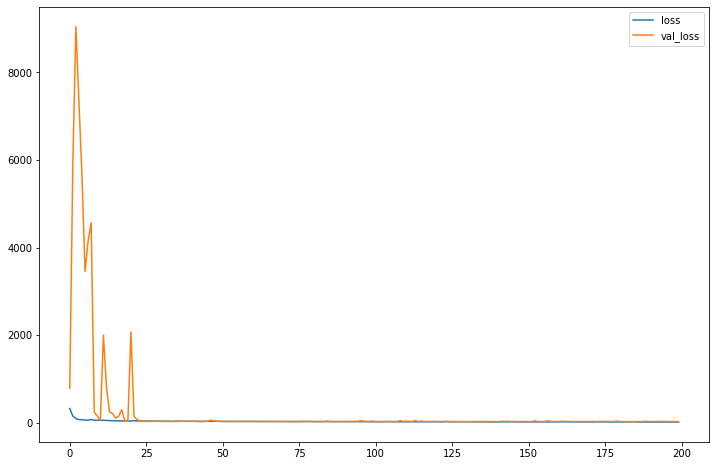

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(12,8))

In [ ]:
# make predictions on the testing data
print("predicting house prices...")
preds = model.predict([test_dfX, testImagesX])

predicting house prices...


In [ ]:
import locale
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_houses["price"].mean(), grouping=True),
	locale.currency(df_houses["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 27.07%, std: 28.93%


MAE: 0.023319311259070424
MSE: 0.0015082902481191808
RMSE: 0.03883671263275486
VarScore: 0.6464413266893991


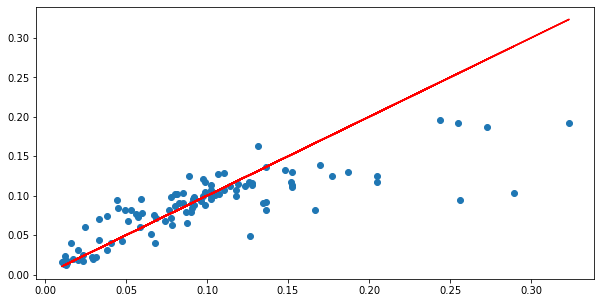

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(testY, preds.flatten()))  
print('MSE:', metrics.mean_squared_error(testY, preds.flatten()))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(testY, preds.flatten())))
print('VarScore:',metrics.explained_variance_score(testY,preds.flatten()))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(testY,preds.flatten())
# Perfect predictions
plt.plot(testY,testY,'r')

In [ ]:
print("R2 score =", round(metrics.r2_score(testY,preds.flatten()), 2))

R2 score = 0.63
